# Training Logistic Regression via Stochastic Gradient Descent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient descent. I will:
* Write a function to compute the derivative of log likelihood function with respect to a single coefficient.
* Implement stochastic gradient descent.
* Compare convergence of stochastic gradient descent with that of batch gradient descent.


In [137]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import scipy.io
from PIL import Image
from scipy import ndimage
import csv
import math
import os
import sys
import sklearn
import sklearn.datasets
from sklearn.preprocessing import scale

%matplotlib inline
# plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

from __future__ import division

# GD vs. SGD vs. Mini-batch GD:

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate" toward the minimum rather than converge smoothly. Here is an illustration of this: 

<img src="images/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>


In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

<img src="images/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

# Function for loading data:

In [138]:
def load_data(file_name):
    """
    This function load the data into the data structures that we need.
    """
    X = np.loadtxt(file_name, dtype='float', delimiter=',', usecols=np.arange(3,13))
    X1 = scale(X, axis=1)
    X = np.hstack((np.ones((X.shape[0],1)), X1))

    cl = np.loadtxt(file_name, dtype='str', delimiter=',', usecols=[1])
    # Set Malignant to be 1 and Benign to be 0
    y = (cl == 'M').astype(float)

    train_set_x = X
    train_set_y = y

    test_set_x = train_set_x
    test_set_y = train_set_y
    
    return (train_set_x, train_set_y, test_set_x, test_set_y)

## Function to load the wbdc.csv file

In [141]:
def load_wbdc_data():
    file_name = '../../../data/wdbc.csv'
    train_set_x, train_set_y, test_set_x, test_set_y = load_data(file_name)
    
    return (train_set_x, train_set_y, test_set_x, test_set_y)

train_set_x, train_set_y, _, _ = load_wbdc_data()
print('train_set_x.shape:', train_set_x.shape)
print('train_set_y.shape:', train_set_y.shape)

('train_set_x.shape:', (569, 11))
('train_set_y.shape:', (569,))


## Function to load a dataset from sklearn datasets

('train_set_x.shape:', (500, 2))
('train_set_y.shape:', (500,))


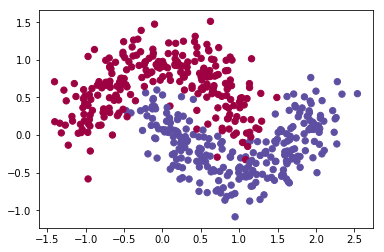

In [142]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=500, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
#     train_X = train_X.T
#     train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

train_set_x, train_set_y = load_dataset()
print('train_set_x.shape:', train_set_x.shape)
print('train_set_y.shape:', train_set_y.shape)

## function to load breast cancer dataset 

In [143]:
from sklearn.datasets import load_breast_cancer

def load_breast_cancer_dataset():
    (X_cancer, y_cancer) = load_breast_cancer(return_X_y=True)
    
    return X_cancer, y_cancer

train_set_x, train_set_y = load_breast_cancer_dataset()
print('train_set_x.shape:', train_set_x.shape)
print('train_set_y.shape:', train_set_y.shape)


('train_set_x.shape:', (569, 30))
('train_set_y.shape:', (569,))


## Shuffle and Partitioning of the data

In [144]:
# GRADED FUNCTION: random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1)* mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[(k+1) * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[(k+1) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [145]:
# Unit testing function

train_set_x, train_set_y, _, _ = load_wbdc_data()
# train_set_y = train_set_y.reshape(train_set_y.shape[0],1)
mini_batch_size = 64

print(train_set_y.shape)

mini_batches = random_mini_batches(train_set_x, train_set_y, mini_batch_size=mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))

print ("shape of the last mini_batch_X: " + str(mini_batches[len(mini_batches)-1][0].shape))
print ("shape of the last mini_batch_Y: " + str(mini_batches[len(mini_batches)-1][1].shape))


print("number of mini_batches", len(mini_batches))

(569,)
shape of the 1st mini_batch_X: (64, 11)
shape of the 2nd mini_batch_X: (64, 11)
shape of the 3rd mini_batch_X: (64, 11)
shape of the 1st mini_batch_Y: (64,)
shape of the 2nd mini_batch_Y: (64,)
shape of the 3rd mini_batch_Y: (64,)
shape of the last mini_batch_X: (57, 11)
shape of the last mini_batch_Y: (57,)
('number of mini_batches', 9)


In [146]:
def predict_probability(feature_matrix, coefficients):
    '''
    produces probablistic estimate for P(y_i = +1 | x_i, w).
    estimate ranges between 0 and 1.
    '''
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix, coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1. / (1.+np.exp(-score))    
    return predictions

## Derivative of log likelihood with respect to a single coefficient

**The derivative of log likelihood with respect to a single coefficient** is as follows:

$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

This function accepts the following two parameters:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 

In [147]:
def feature_derivative(errors, feature): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors, feature)

    return derivative

To track the performance of stochastic gradient descent, I implement a function for computing **average log likelihood**. 

$$\ell\ell_A(\mathbf{w}) = \color{red}{\frac{1}{N}} \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) $$

In [214]:
def compute_avg_log_likelihood(feature_matrix, label, coefficients):
    
    indicator = (label==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
    
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]
    
    lp = -np.sum((indicator-1)*scores - logexp)/len(feature_matrix)
#     lp = -np.sum((indicator-1)*scores - logexp)

    
    return lp

## Implementing stochastic gradient descent

Here is the function to fit a logistic regression model using gradient descent:

In [283]:
from math import sqrt
def logistic_regression_SG(feature_matrix, label, initial_coefficients, step_size, batch_size, num_epochs, verbose = False, decay_time_step = False):
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    seed = 0
#     # set seed=1 to produce consistent results
#     np.random.seed(seed=1)
#     # Shuffle the data before starting
#     permutation = np.random.permutation(len(feature_matrix))
#     feature_matrix = feature_matrix[permutation,:]
#     label = label[permutation]

    itr = 0

    
    # Do a linear scan over data
    for i in range(num_epochs):
        
        seed = seed + 1
        minibatches = random_mini_batches(feature_matrix, label, batch_size, seed)
        k = 0  # index of current batch
        C = step_size   # C is the Robbins_Monro parameter
        for minibatch in minibatches:
            max_iter = num_epochs * len(minibatches)
            (minibatch_X, minibatch_Y) = minibatch
            itr = itr + 1

            # Predict P(y_i = +1|x_i,w) using your predict_probability() function
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
            predictions = predict_probability(minibatch_X, coefficients)
        
            # Compute indicator value for (y_i = +1)
            # Make sure to slice the i-th entry with [i:i+batch_size]
            indicator = (minibatch_Y==+1)

        
            # Compute the errors as indicator - predictions
            errors = indicator - predictions

            for j in range(len(coefficients)): # loop over each coefficient
                # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
                # Compute the derivative for coefficients[j] and save it to derivative.
                # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
                derivative = feature_derivative(errors, minibatch_X[:,j])


                # compute the product of the step size, the derivative, and the **normalization constant** (1./batch_size)
                if decay_time_step == True:
                    step_size = C / (1. + i)
                coefficients[j] += (1./batch_size) * step_size* derivative
#                 coefficients[j] += step_size* derivative


            # Checking whether log likelihood is increasing
            # Print the log likelihood over the *current batch*
            lp = compute_avg_log_likelihood(minibatch_X, minibatch_Y,
                                            coefficients)
            log_likelihood_all.append(lp)
            if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
             or itr % 10000 == 0 or itr == max_iter-1:
                data_size = len(feature_matrix)
                print ('Iteration %*d: Average log likelihood (of data points in batch [%0*d:%0*d]) = %.8f' % \
                    (int(np.ceil(np.log10(max_iter))), itr, \
                     int(np.ceil(np.log10(data_size))), k, \
                     int(np.ceil(np.log10(data_size))), k+batch_size, lp))
            
            k = k + batch_size
                
    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [284]:
# Unit testing

sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_label = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_label, np.zeros(3),
                                                  step_size=1., batch_size=2, num_epochs = 2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, -np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 1: Average log likelihood (of data points in batch [0:2]) = 0.33774513
Iteration 2: Average log likelihood (of data points in batch [0:2]) = 0.23455309
-------------------------------------------------------------------------------------
('Coefficients learned                 :', array([-0.09755757,  0.68242552, -0.7799831 ]))
('Average log likelihood per-iteration :', [0.33774513108142956, 0.2345530939410341])
-------------------------------------------------------------------------------------
Test passed!


## Compare convergence behavior of stochastic gradient descent

We now **run stochastic gradient descent** over the **feature_matrix_train** for 10 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = 1`
* `max_iter = 10`

In [250]:
train_set_x, train_set_y, _,_= load_wbdc_data()


coefficients, log_likelihood = logistic_regression_SG(train_set_x, train_set_y,
                                        initial_coefficients=np.zeros(11),
                                        step_size=5e-1, batch_size=1, num_epochs=10)

Iteration    1: Average log likelihood (of data points in batch [000:001]) = 0.06196759
Iteration    2: Average log likelihood (of data points in batch [001:002]) = 0.08520708
Iteration    3: Average log likelihood (of data points in batch [002:003]) = 0.06952745
Iteration    4: Average log likelihood (of data points in batch [003:004]) = 0.07886236
Iteration    5: Average log likelihood (of data points in batch [004:005]) = 0.05273577
Iteration    6: Average log likelihood (of data points in batch [005:006]) = 0.03999563
Iteration    7: Average log likelihood (of data points in batch [006:007]) = 0.03231575
Iteration    8: Average log likelihood (of data points in batch [007:008]) = 0.02720444
Iteration    9: Average log likelihood (of data points in batch [008:009]) = 0.15618787
Iteration   10: Average log likelihood (of data points in batch [009:010]) = 0.07406642
Iteration   11: Average log likelihood (of data points in batch [010:011]) = 0.05002088
Iteration   12: Average log like

Now run **batch gradient descent** over the **feature_matrix_train** for 200 iterations using:
* `initial_coefficients = np.zeros(194)`
* `step_size = 5e-1`
* `batch_size = len(feature_matrix_train)`
* `max_iter = 200`

In [251]:
train_set_x, train_set_y, _,_= load_wbdc_data()

coefficients_batch, log_likelihood_batch = logistic_regression_SG(train_set_x, train_set_y,
                                        initial_coefficients=np.zeros(11),
                                        step_size=5e-1, batch_size=len(train_set_x), num_epochs=3000)


Iteration    1: Average log likelihood (of data points in batch [000:569]) = 0.66323775
Iteration    2: Average log likelihood (of data points in batch [000:569]) = 0.65906850
Iteration    3: Average log likelihood (of data points in batch [000:569]) = 0.65811780
Iteration    4: Average log likelihood (of data points in batch [000:569]) = 0.65736903
Iteration    5: Average log likelihood (of data points in batch [000:569]) = 0.65663969
Iteration    6: Average log likelihood (of data points in batch [000:569]) = 0.65591413
Iteration    7: Average log likelihood (of data points in batch [000:569]) = 0.65519110
Iteration    8: Average log likelihood (of data points in batch [000:569]) = 0.65447047
Iteration    9: Average log likelihood (of data points in batch [000:569]) = 0.65375225
Iteration   10: Average log likelihood (of data points in batch [000:569]) = 0.65303642
Iteration   11: Average log likelihood (of data points in batch [000:569]) = 0.65232296
Iteration   12: Average log like

## Make "passes" over the dataset


To make a fair comparison betweeen stochastic gradient descent and batch gradient descent, we measure the average log likelihood as a function of the number of passes (defined as follows):
$$
[\text{# of passes}] = \frac{[\text{# of data points touched so far}]}{[\text{size of dataset}]}
$$

## Log likelihood plots for stochastic gradient descent


With the terminology in mind, let us run stochastic gradient descent for 10 passes. We will use
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [252]:
train_set_x, train_set_y, _,_ = load_wbdc_data()

step_size = 1e-1
batch_size = 10
num_passes = 10
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=1e-1, batch_size=10, num_epochs = num_passes)

Iteration   1: Average log likelihood (of data points in batch [000:010]) = 0.68357789
Iteration   2: Average log likelihood (of data points in batch [010:020]) = 0.66732967
Iteration   3: Average log likelihood (of data points in batch [020:030]) = 0.69388699
Iteration   4: Average log likelihood (of data points in batch [030:040]) = 0.69339084
Iteration   5: Average log likelihood (of data points in batch [040:050]) = 0.59586568
Iteration   6: Average log likelihood (of data points in batch [050:060]) = 0.62322281
Iteration   7: Average log likelihood (of data points in batch [060:070]) = 0.54350607
Iteration   8: Average log likelihood (of data points in batch [070:080]) = 0.75220598
Iteration   9: Average log likelihood (of data points in batch [080:090]) = 0.67233310
Iteration  10: Average log likelihood (of data points in batch [090:100]) = 0.62229596
Iteration  11: Average log likelihood (of data points in batch [100:110]) = 0.54183806
Iteration  12: Average log likelihood (of d

### A utility function to plot the average log likelihood as a function of the number of passes.

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})

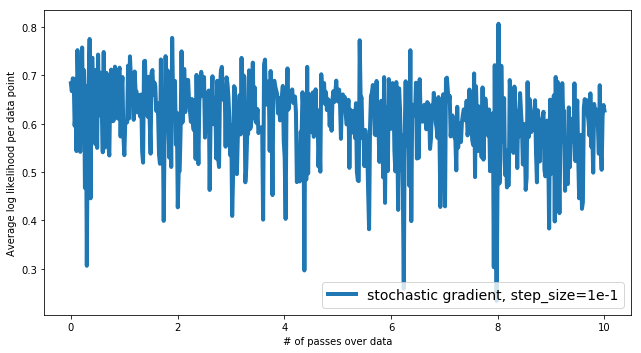

In [254]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=10,
          label='stochastic gradient, step_size=1e-1')

## Smoothing the stochastic gradient descent curve

The plotted line oscillates so much that it is hard to see whether the log likelihood is improving. In my plot, I apply a simple smoothing operation using the parameter `smoothing_window`. The smoothing is simply a [moving average](https://en.wikipedia.org/wiki/Moving_average) of log likelihood over the last `smoothing_window` "iterations" of  stochastic gradient descent.

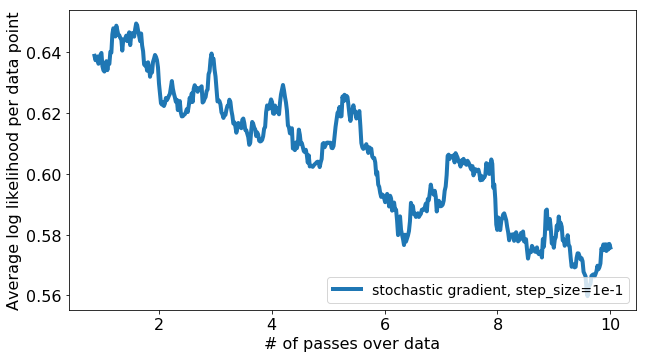

In [255]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=10,
          smoothing_window=50, label='stochastic gradient, step_size=1e-1')

## Stochastic gradient descent vs batch gradient descent

To compare convergence rates for stochastic gradient descent with batch gradient descent, we call `make_plot()` multiple times in the same cell.

We are comparing:
* **stochastic gradient descent**: `step_size = 0.1`, `batch_size=100`
* **batch gradient descent**: `step_size = 0.5`, `batch_size=len(feature_matrix_train)`

Write code to run stochastic gradient descent for 200 passes using:
* `step_size=1e-1`
* `batch_size=100`
* `initial_coefficients` to all zeros.

In [256]:
step_size = 1e-1
batch_size = 10
num_passes = 3000
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=1e-1, batch_size=10, num_epochs=num_passes)

Iteration      1: Average log likelihood (of data points in batch [000:010]) = 0.68357789
Iteration      2: Average log likelihood (of data points in batch [010:020]) = 0.66732967
Iteration      3: Average log likelihood (of data points in batch [020:030]) = 0.69388699
Iteration      4: Average log likelihood (of data points in batch [030:040]) = 0.69339084
Iteration      5: Average log likelihood (of data points in batch [040:050]) = 0.59586568
Iteration      6: Average log likelihood (of data points in batch [050:060]) = 0.62322281
Iteration      7: Average log likelihood (of data points in batch [060:070]) = 0.54350607
Iteration      8: Average log likelihood (of data points in batch [070:080]) = 0.75220598
Iteration      9: Average log likelihood (of data points in batch [080:090]) = 0.67233310
Iteration     10: Average log likelihood (of data points in batch [090:100]) = 0.62229596
Iteration     11: Average log likelihood (of data points in batch [100:110]) = 0.54183806
Iteration 

We compare the convergence of stochastic gradient descent and batch gradient descent in the following cell. Note that we apply smoothing with `smoothing_window=30`.

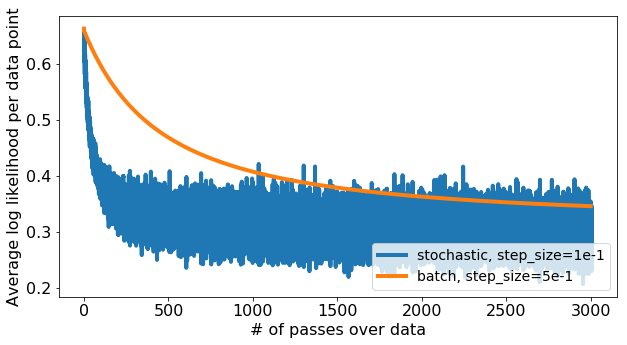

In [257]:
make_plot(log_likelihood_sgd, len_data=len(train_set_x), batch_size=10,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(train_set_x), batch_size=len(train_set_x),
          smoothing_window=1, label='batch, step_size=5e-1')

## Explore the effects of step sizes on stochastic gradient descent


To start, I explore a wide range of step sizes that are equally spaced in the log space. I run stochastic gradient descent with `step_size` set to 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, and 1e2. 
* `initial_coefficients=np.zeros(194)`
* `batch_size=100`
* `max_iter` initialized so as to run 10 passes over the data.

In [281]:
batch_size = 10
num_passes = 100
num_iterations = num_passes * int(len(train_set_x)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(train_set_x, train_set_y,
                                       initial_coefficients=np.zeros(11),
                                       step_size=step_size, batch_size=10, num_epochs = num_passes)

Iteration    1: Average log likelihood (of data points in batch [000:010]) = 0.69313610
Iteration    2: Average log likelihood (of data points in batch [010:020]) = 0.69312493
Iteration    3: Average log likelihood (of data points in batch [020:030]) = 0.69314664
Iteration    4: Average log likelihood (of data points in batch [030:040]) = 0.69314675
Iteration    5: Average log likelihood (of data points in batch [040:050]) = 0.69301467
Iteration    6: Average log likelihood (of data points in batch [050:060]) = 0.69301448
Iteration    7: Average log likelihood (of data points in batch [060:070]) = 0.69285012
Iteration    8: Average log likelihood (of data points in batch [070:080]) = 0.69323422
Iteration    9: Average log likelihood (of data points in batch [080:090]) = 0.69304778
Iteration   10: Average log likelihood (of data points in batch [090:100]) = 0.69290482
Iteration   11: Average log likelihood (of data points in batch [100:110]) = 0.69268553
Iteration   12: Average log like

Iteration 4000: Average log likelihood (of data points in batch [090:100]) = 0.18315717
Iteration 5000: Average log likelihood (of data points in batch [400:410]) = 0.44058783
Iteration 5699: Average log likelihood (of data points in batch [550:560]) = 0.46106549
Iteration    1: Average log likelihood (of data points in batch [000:010]) = 0.72647924
Iteration    2: Average log likelihood (of data points in batch [010:020]) = 1.17293092
Iteration    3: Average log likelihood (of data points in batch [020:030]) = 0.92074885
Iteration    4: Average log likelihood (of data points in batch [030:040]) = 1.09510163
Iteration    5: Average log likelihood (of data points in batch [040:050]) = 0.50038152
Iteration    6: Average log likelihood (of data points in batch [050:060]) = 0.61206151
Iteration    7: Average log likelihood (of data points in batch [060:070]) = 0.56201279
Iteration    8: Average log likelihood (of data points in batch [070:080]) = 1.33948055
Iteration    9: Average log like

/Users/anvaribs/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in exp
/Users/anvaribs/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in exp



Iteration  800: Average log likelihood (of data points in batch [010:020]) = -0.00000000
Iteration  900: Average log likelihood (of data points in batch [440:450]) = -0.00000000
Iteration 1000: Average log likelihood (of data points in batch [300:310]) = 12.02322230
Iteration 2000: Average log likelihood (of data points in batch [040:050]) = 12.52389982
Iteration 3000: Average log likelihood (of data points in batch [350:360]) = 23.85802504
Iteration 4000: Average log likelihood (of data points in batch [090:100]) = -0.00000000
Iteration 5000: Average log likelihood (of data points in batch [400:410]) = 4.93050967
Iteration 5699: Average log likelihood (of data points in batch [550:560]) = 29.13421320


### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

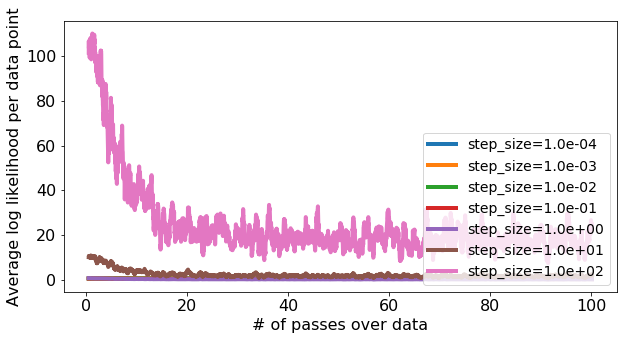

In [259]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_set_x), batch_size=10,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let me remove the step size `step_size = 1e2` and  `step_size = 1e1` plot the rest of the curves.

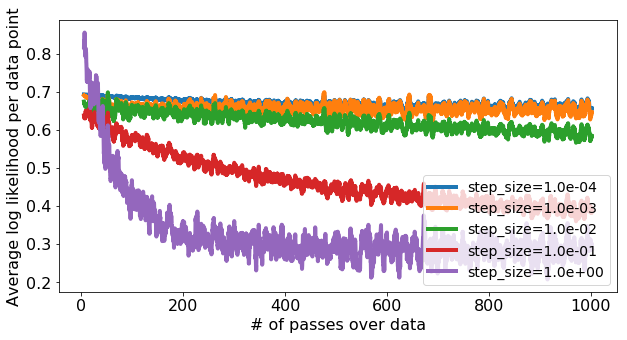

In [261]:
for step_size in np.logspace(-4, 2, num=7)[0:5]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_set_x), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

### Plotting the log likelihood as a function of passes for each step size

Now, we will plot the change in log likelihood using the `make_plot` for each of the following values of `step_size`:

* `step_size = 1e-4`
* `step_size = 1e-3`
* `step_size = 1e-2`
* `step_size = 1e-1`
* `step_size = 1e0`
* `step_size = 1e1`
* `step_size = 1e2`

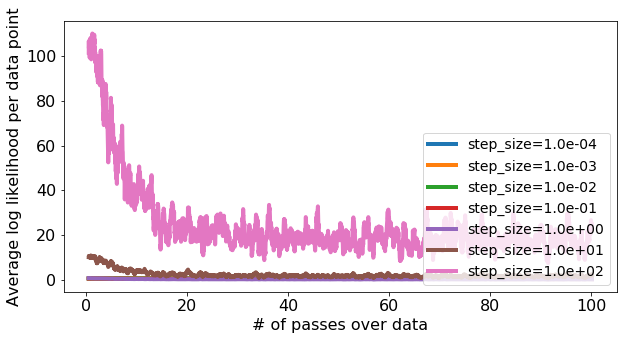

In [62]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_set_x), batch_size=10,
              smoothing_window=30, label='step_size=%.1e'%step_size)

Now, let me remove the step size `step_size = 1e2` and plot the rest of the curves.

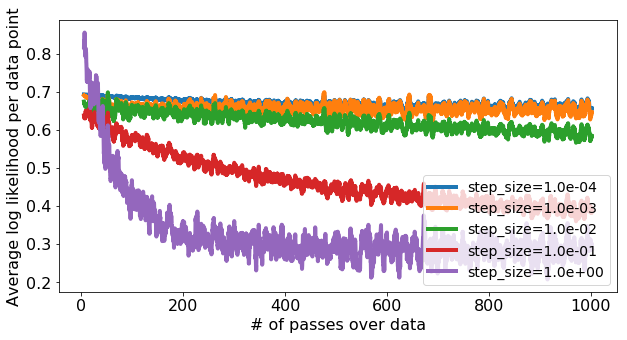

In [63]:
for step_size in np.logspace(-4, 2, num=7)[0:5]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_set_x), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

In [64]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

In [25]:
def compute_cost(a3, Y):
    
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.sum(logprobs)
    
    return cost

In [26]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

# train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [27]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()